In [3]:
!saved_model_cli show --dir /home/mkk/Transferências/sp_v5 --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['image'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, -1, -1, 1)
        name: superpoint/image:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['descriptors'] tensor_info:
        dtype: DT_FLOAT
        shape: (1, -1, -1, 256)
        name: superpoint/descriptors:0
    outputs['descriptors_raw'] tensor_info:
        dtype: DT_FLOAT
        shape: (1, -1, -1, 256)
        name: superpoint/descriptors_raw:0
    outputs['logits'] tensor_info:
        dtype: DT_FLOAT
        shape: (1, -1, -1, 65)
        name: superpoint/logits:0
    outputs['pred'] tensor_info:
        dtype: DT_INT32
        shape: (1, -1, -1)
        name: superpoint/pred:0
    outputs['prob'] tensor_info:
        dtype: DT_FLOAT
        shape: (1, -1, -1)
        name: superpoint/prob

In [ ]:
import os
os.

In [1]:
import tensorflow as tf

In [ ]:
super_point_model = tf.saved_model.load("/home/mkk/Transferências/sp_v5", tags=['serve'])

In [ ]:
infer = loaded.signatures["serving_default"]

In [ ]:
import sys

In [156]:
from superglue.keypoint_extractors import SuperPointExtractor, Keypoints

In [3]:
extractor = SuperPointExtractor("/home/mkk/Transferências/sp_v5")

In [4]:
from PIL import Image
import numpy as np
import cv2

In [296]:
image = Image.open("/home/mkk/Downloads/a.jpg")
image = image.resize((512, 512))

In [368]:
image_np = np.array(image)

In [369]:
keypoints = extractor.extract(image_np)

In [373]:
img_with_keypoints = cv2.drawKeypoints(
    image_np, 
    Keypoints.convert_numpy_keypoints_to_cv(keypoints.numpy_keypoints()), 
    outImage=None, color=(0, 0, 255), 
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

In [374]:
keypoints.numpy_keypoints().shape

(689, 2)

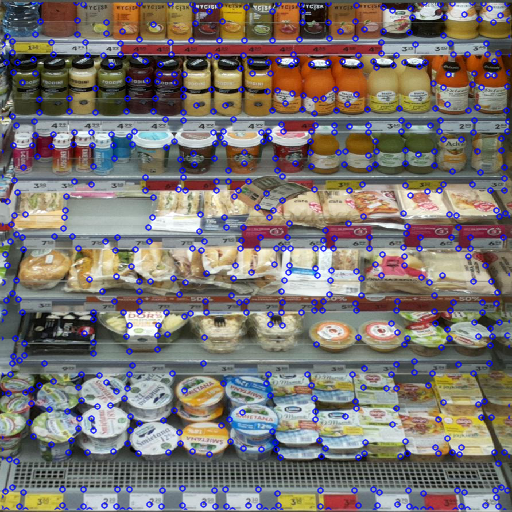

In [375]:
Image.fromarray(img_with_keypoints)

In [376]:
from superglue.homographies import homographic_augmentation, invert_homography, warp_points

In [377]:
data = {"image": image_np, "keypoints": keypoints.numpy_keypoints()}
transformed_data = homographic_augmentation(data, add_homography=True, params={}, valid_border_margin=0)

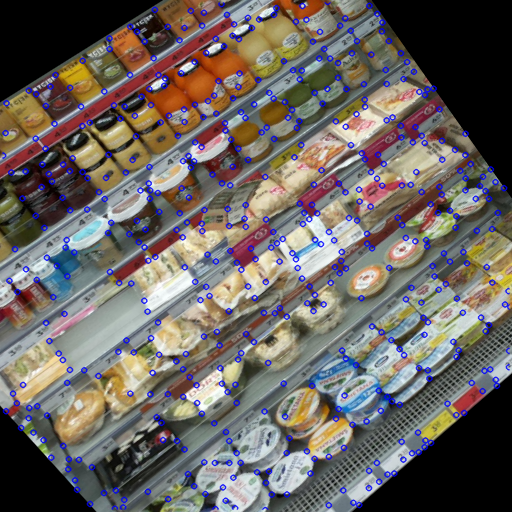

In [378]:
img_with_keypoints = cv2.drawKeypoints(
    transformed_data['image'].numpy(), 
    Keypoints.convert_numpy_keypoints_to_cv(transformed_data['keypoints'].numpy()), 
    outImage=None, color=(0, 0, 255), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)
Image.fromarray(img_with_keypoints)

In [379]:
# Image.fromarray(transformed_data['image'].numpy())
keypoints2 = extractor.extract(transformed_data['image'].numpy())

In [380]:
len(keypoints2.keypoints)

524

In [381]:
img_with_keypoints = cv2.drawKeypoints(
    transformed_data['image'].numpy(), 
    keypoints2.keypoints, outImage=None, color=(0, 0, 255), 
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

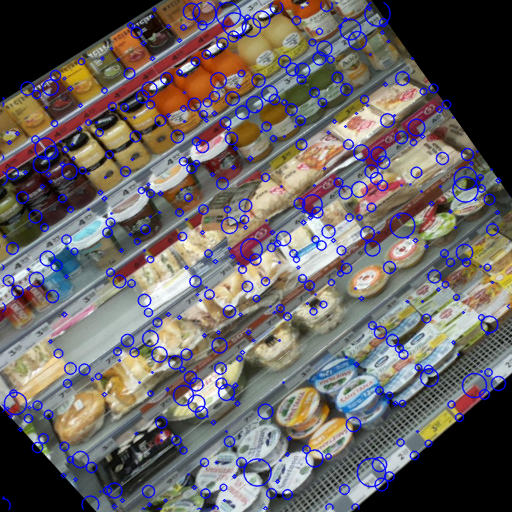

In [382]:
Image.fromarray(img_with_keypoints)

In [383]:
# transformed_data['keypoints']

In [384]:
import tensorflow as tf

In [385]:
inv_homography = invert_homography(tf.expand_dims(transformed_data['homography'], 0))

In [386]:
reprojected_points = warp_points(keypoints2.numpy_keypoints(), inv_homography[0])

In [388]:
img_with_keypoints = cv2.drawKeypoints(
    image_np, Keypoints.convert_numpy_keypoints_to_cv(reprojected_points.numpy()), outImage=None, color=(0, 0, 255), 
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

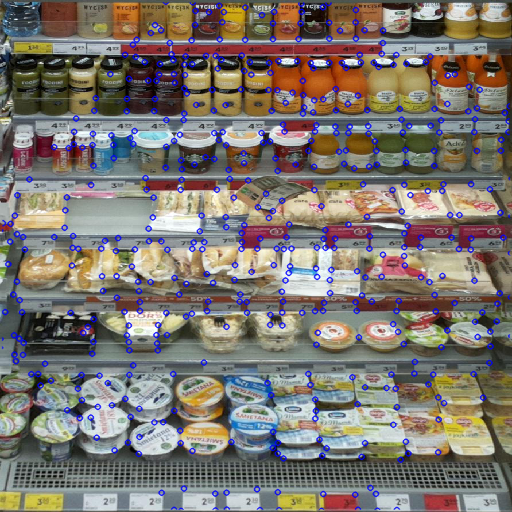

In [389]:
Image.fromarray(img_with_keypoints)

In [390]:
from scipy.spatial import distance_matrix

In [401]:
match_matrix = distance_matrix(keypoints.numpy_keypoints(), reprojected_points.numpy())

In [417]:
k1 = keypoints.numpy_keypoints()
k2 = reprojected_points.numpy()
dmat = np.sqrt(np.maximum(np.sum(k1**2, -1, keepdims=True) - 2 * k1 @ k2.T + np.sum(k2**2, -1, keepdims=True).T, 0.0))
dmat

array([[402.32081465, 295.59037821, 494.15504975, ..., 564.23993893,
         55.16326296, 185.92045361],
       [454.25967053, 453.9677411 , 201.29148143, ..., 534.12916529,
        406.85285974, 333.41294949],
       [371.91518149, 263.37834773, 481.82113279, ..., 534.09777086,
         62.97826701, 209.63294206],
       ...,
       [410.89831109, 380.28349924, 252.00584841, ..., 524.67362187,
        282.31596543, 208.22027771],
       [304.51210025, 232.94148823, 318.0065092 , ..., 453.57480739,
        124.30560956, 168.29901878],
       [434.78023946, 386.4589131 , 315.29067235, ..., 562.28949387,
        237.76972557, 142.32700906]])

In [422]:
np.max(np.abs(match_matrix - dmat))

0.034664901847368076

In [425]:
dmat.min(-1) < 5 

array([False,  True, False,  True, False,  True,  True, False, False,
        True, False,  True, False, False,  True, False,  True,  True,
        True, False, False, False, False,  True,  True, False, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True, False, False, False,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True, False,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,